In [1]:
# Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

%matplotlib inline

## Data engineering

In [2]:
# let's import the vst-transformed count matrix (rows = samples, col = genes; last col = label)
lusc_data = pd.read_csv("./datasets/LUSC_geneReadCount_VST.csv")

In [3]:
lusc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551 entries, TCGA-94-7943-01A-11R-2187-07 to TCGA-51-4079-01A-01R-1100-07
Columns: 39753 entries, ENSG00000000003 to label
dtypes: float64(39752), object(1)
memory usage: 167.1+ MB


In [4]:
lusc_data.head(n = 2)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920,label
TCGA-94-7943-01A-11R-2187-07,12.598295,3.347690,11.399091,9.710489,9.840727,9.545426,10.041732,12.644989,14.885584,11.249983,...,3.815171,2.867519,4.105474,6.292337,4.185603,2.867519,2.867519,5.871927,3.815171,TP
TCGA-68-8251-01A-11R-2296-07,11.612011,2.867519,10.177441,9.713037,10.129734,9.244418,11.915565,11.611566,11.623539,11.601289,...,3.601768,2.867519,3.762122,5.592759,4.582716,2.867519,3.601768,5.733117,3.601768,TP


In [5]:
lusc_data.describe()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281849,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,...,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,11.506768,3.210376,11.134674,9.733453,9.366600,9.736418,11.722034,11.641264,12.855367,11.043012,...,4.041995,4.042448,3.120010,3.606434,5.596421,4.555536,2.958657,3.082710,6.137523,4.073239
std,0.787590,0.489220,0.571272,0.434617,0.852139,1.322106,1.258561,0.614512,1.675005,0.487124,...,0.453254,0.880900,0.491202,0.442423,0.718426,0.651652,0.251155,0.318855,0.801420,0.684128
min,7.633507,2.867519,9.681449,8.687156,6.778143,6.532816,7.149722,9.207351,7.908137,9.835914,...,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,4.286747,2.867519
25%,11.028481,2.867519,10.740382,9.414906,8.960434,8.812821,10.870713,11.260034,11.560327,10.676899,...,3.767203,3.494788,2.867519,3.377046,5.174235,4.145110,2.867519,2.867519,5.601021,3.640888
50%,11.528563,2.867519,11.121858,9.711340,9.450394,9.633702,11.892007,11.657195,12.795053,11.006232,...,4.053541,3.864506,2.867519,3.636971,5.694652,4.508810,2.867519,2.867519,6.058458,3.970914
75%,11.998324,3.480934,11.516073,9.988039,9.921684,10.525566,12.618282,12.009649,14.104870,11.355443,...,4.298340,4.426093,3.352355,3.874470,6.071015,4.917957,2.867519,3.383177,6.563879,4.382519
max,15.404360,7.775136,13.403787,11.144561,11.439552,13.296483,14.531509,13.998175,17.055902,12.420048,...,5.662153,7.031399,6.139507,4.837585,7.661138,8.614201,5.295860,4.613722,9.488109,7.189747


In [6]:
# let's encode the labels
lusc_data = lusc_data.replace("NT", 0) # NT (nromal tissue) as 0
lusc_data = lusc_data.replace("TP", 1) # TP (primary tumour) as 1

In [7]:
# let's check the count of each label type
print(lusc_data["label"].value_counts())

1    502
0     49
Name: label, dtype: int64


In [8]:
# let's construct the target vector
labels = np.array(lusc_data['label'])
labels.shape

(551,)

In [9]:
# let's construct the feature matrix (by dropping the label column)
features = lusc_data.drop('label', axis = 1)
features.shape

(551, 39752)

In [10]:
# let's check if we have any missing variables
features.isnull().sum().sum()

0

In [11]:
# let's import the list of features (genes) along with the differential testing statitsics
geneStats = pd.read_csv("./datasets/geneStats.csv", header = 0)
print(geneStats.shape)
geneStats.head()

(39610, 8)


,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82


In [12]:
# let's filter the genes by signficancy (padj <= 0.01) and sort by log2FC
ranked_genes = geneStats[geneStats['padj'] <= 0.01].sort_values(by = 'log2FoldChange', ascending = False, key = abs)
ranked_genes

,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82
...,...,...,...,...,...,...,...,...
34970,ENSG00000136709,WDR33,3990.0,0.172,0.049,3.523,4.270000e-04,7.870000e-04
34991,ENSG00000102974,CTCF,3590.0,0.171,0.052,3.290,1.000000e-03,1.770000e-03
35120,ENSG00000161813,LARP4,3370.0,0.166,0.061,2.732,6.290000e-03,1.000000e-02
35437,ENSG00000182149,IST1,7100.0,-0.154,0.052,-2.949,3.190000e-03,5.280000e-03


In [13]:
# let's take the top n genes as features 
ranked_genes10   = ranked_genes.iloc[:10,:2]
ranked_genes20   = ranked_genes.iloc[:20,:2]
ranked_genes40   = ranked_genes.iloc[:40,:2]
ranked_genes100  = ranked_genes.iloc[:100,:2]
ranked_genes1000 = ranked_genes.iloc[:1000,:2]

In [14]:
ranked_genes.iloc[:40,:]

,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82
5,ENSG00000128714,HOXD13,377.0,9.545,0.441,21.620,1.160000e-103,1.230000e-101
6,ENSG00000236956,NF1P8,25.4,9.532,0.737,12.935,2.860000e-38,3.980000e-37
7,ENSG00000132446,FTHL17,20.4,9.507,0.985,9.653,4.770000e-22,3.110000e-21
8,ENSG00000123584,MAGEA9,33.9,9.498,0.738,12.864,7.140000e-38,9.780000e-37
9,ENSG00000170516,COX7B2,31.1,9.469,0.821,11.534,8.890000e-31,8.860000e-30


In [15]:
# let's subset the feature matrix to keep only top 40 ranked genes
features_genes40 = features.filter(ranked_genes40['ensembl_gene_id'])
# rename columns: Ensembl Ids -> RefSeq Ids
features_genes40.rename(columns = dict(zip(ranked_genes40['ensembl_gene_id'], ranked_genes40['hgnc_symbol'])), inplace= True)
features_genes40

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
TCGA-94-7943-01A-11R-2187-07,2.867519,2.867519,3.347690,3.815171,5.329022,5.234964,2.867519,2.867519,2.867519,2.867519,...,3.347690,4.018372,6.828737,4.329596,3.347690,12.297560,3.815171,4.772655,4.571647,3.815171
TCGA-68-8251-01A-11R-2296-07,4.207374,2.867519,2.867519,3.895277,4.293196,10.343212,2.867519,10.073947,8.921288,2.867519,...,3.601768,5.221602,9.593678,6.725751,3.895277,4.965361,5.562891,6.165918,5.678669,5.297088
TCGA-33-A5GW-01A-11R-A27Q-07,3.439060,2.867519,4.326600,12.353466,10.270707,7.112492,2.867519,3.670685,2.867519,3.439060,...,2.867519,11.566494,14.448280,4.795128,5.134576,9.246744,7.917821,5.965390,7.075626,8.578642
TCGA-85-8070-01A-11R-2247-07,2.867519,3.504046,2.867519,11.993517,12.313800,6.674558,7.348623,3.504046,7.050849,6.653913,...,3.504046,10.227045,9.181157,4.672567,11.780299,12.582205,8.601480,6.500372,2.867519,7.018981
TCGA-85-8479-01A-11R-2326-07,3.422884,2.867519,2.867519,2.867519,3.422884,6.354543,2.867519,2.867519,2.867519,2.867519,...,3.422884,3.648222,13.844222,4.287902,2.867519,3.422884,3.422884,3.648222,5.926021,4.461587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-21-1071-01A-01R-0692-07,5.957102,2.867519,2.867519,11.501332,12.113274,3.395251,7.369443,2.867519,2.867519,4.886685,...,2.867519,10.810545,10.919005,8.018389,5.492238,11.185012,5.203598,6.192116,6.629075,4.127031
TCGA-33-AASD-01A-11R-A405-07,3.756927,2.867519,2.867519,11.399134,11.985071,10.346303,8.097780,4.285283,2.867519,4.364468,...,4.805232,10.223865,9.963406,8.999000,11.479917,13.114847,3.386388,7.391543,8.346563,7.039593
TCGA-39-5029-01A-01R-1443-07,6.491208,2.867519,3.570316,11.166503,11.494353,7.680245,4.451329,6.118348,2.867519,3.963233,...,7.570416,5.469437,10.863502,9.293369,9.797325,8.333914,4.575559,7.361216,7.764795,4.791133
TCGA-MF-A522-01A-11R-A262-07,4.792042,3.417526,2.867519,12.031591,7.812429,6.627514,5.877308,2.867519,2.867519,2.867519,...,3.417526,10.997737,12.141948,10.313835,10.960911,9.669557,4.597270,7.531492,7.531492,7.182010


In [16]:
# let's split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_genes40, labels, test_size = 0.20, random_state = 2)

In [17]:
# let's check the shape of each set
(X_train.shape,
 y_train.shape,
 X_test.shape,
 y_test.shape)

((440, 40), (440,), (111, 40), (111,))

Variables measured at differnet scales do not contribute equally to model fitting and might introduce a bias. One way to deal with it is feature-wise standarisation, i.e. mean = 0, and SD = 1 prior to model fitting.
To avoid data leakage from the test set into the training set, I will normalise the training set only and then use the normaliation facotrs, calculated on the training set, to normalise the the testing set.

In [18]:
# let's use `StandardScaler()` to z-score normalise each feature (column) individually.
std_scaler = StandardScaler()
std_X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns = X_train.columns)
std_X_train

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
0,-0.125822,-0.410407,-0.468178,-0.750281,-0.748840,-1.172183,-0.251444,-0.391547,-0.582573,-0.537989,...,-0.200490,-0.472922,-0.295810,-1.379307,-0.287683,-0.143541,-0.958865,0.788803,-0.874578,-1.150125
1,3.345104,0.516306,3.259967,1.235379,1.392860,1.259026,-0.324497,-0.391547,-0.582573,-0.537989,...,-0.266110,1.072777,1.248260,0.438607,1.435699,-0.400462,-0.545117,0.633720,1.077832,1.458165
2,0.116483,4.411059,2.292843,1.537661,1.550212,1.182060,1.476411,-0.391547,-0.108521,0.354622,...,3.984033,1.532202,1.435398,-0.128609,2.002666,-0.672447,0.604970,1.430725,-0.857603,-0.137258
3,-0.676228,1.929830,-0.468178,-0.295275,1.513175,-1.263354,-0.630724,2.545120,-0.582573,-0.537989,...,-0.011710,-0.712277,-0.727908,-1.195196,1.789565,-0.854646,1.595213,1.220694,-1.536347,-0.728298
4,-0.464758,-0.410407,-0.468178,-1.114499,-1.143938,-1.483460,-0.630724,-0.391547,-0.582573,-0.537989,...,-0.541178,-0.829607,-1.962262,-1.434324,-0.796855,-0.708507,-0.958865,-1.708950,-1.536347,-0.862264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,-0.676228,0.389866,-0.468178,0.239653,0.604576,0.592877,-0.098087,3.846841,2.038376,-0.537989,...,2.267705,-0.361135,-1.130350,0.926516,0.429745,-0.631061,1.160072,0.190355,1.939059,-0.191700
436,-0.676228,-0.410407,-0.468178,-0.754765,1.324131,0.628161,-0.630724,-0.391547,-0.582573,-0.537989,...,-0.541178,-0.126928,0.257874,0.261996,-0.576395,2.202093,-0.958865,0.414036,0.351879,0.576907
437,0.562745,-0.410407,0.416804,-0.107066,-0.809550,0.666529,2.297535,-0.391547,-0.582573,-0.537989,...,-0.541178,1.593454,1.216061,0.835189,-0.395457,0.993303,1.407649,1.022074,0.810517,1.068859
438,-0.676228,-0.410407,-0.468178,-0.955877,-1.143938,0.827563,-0.630724,-0.391547,-0.582573,-0.537989,...,-0.218161,-0.967256,0.442748,-1.390857,-0.796855,1.274386,0.356713,0.177496,1.842296,1.607500


In addition, let's normalise the z-score standardised read count using the min-max approach, so that all values are in the range [0, 1]

In [19]:
# let's use `MinMaxScaler()` to Min-Max -> range[0,1] normalise each feature (column)
minmax_scaler = MinMaxScaler()
std_mm_X_train = pd.DataFrame(minmax_scaler.fit_transform(std_X_train), columns = std_X_train.columns)
std_mm_X_train

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
0,0.136872,0.000000,0.000000,0.136475,0.138033,0.095199,0.089273,0.000000,0.000000,0.000000,...,0.054507,0.158145,0.513756,0.053888,0.148749,0.211600,0.000000,0.701947,0.174831,0.000000
1,1.000000,0.149384,0.784065,0.880515,0.886263,0.838747,0.072078,0.000000,0.000000,0.000000,...,0.044008,0.652636,0.891124,0.493801,0.652217,0.135149,0.115349,0.658364,0.690631,0.562570
2,0.197127,0.777209,0.580669,0.993782,0.941236,0.815208,0.495967,0.000000,0.117189,0.152207,...,0.723988,0.799613,0.936861,0.356542,0.817850,0.054216,0.435983,0.882347,0.179315,0.218461
3,0.000000,0.377241,0.000000,0.306969,0.928296,0.067316,0.000000,0.552459,0.000000,0.000000,...,0.084710,0.081571,0.408152,0.098441,0.755595,0.000000,0.712054,0.823322,0.000000,0.090982
4,0.052587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.044036,0.106478,0.040574,0.000000,0.043486,0.000000,0.000000,0.000000,0.062088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.000000,0.129002,0.000000,0.507410,0.610866,0.635016,0.125369,0.797345,0.647919,0.000000,...,0.449393,0.193907,0.309796,0.611869,0.358338,0.066531,0.590741,0.533764,0.918156,0.206718
436,0.000000,0.000000,0.000000,0.134795,0.862251,0.645807,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.268833,0.649076,0.451063,0.064405,0.909580,0.000000,0.596626,0.498844,0.372495
437,0.308100,0.000000,0.186120,0.377492,0.116823,0.657541,0.689238,0.000000,0.000000,0.000000,...,0.000000,0.819208,0.883255,0.589769,0.117264,0.549886,0.659763,0.767504,0.620010,0.478602
438,0.000000,0.000000,0.000000,0.059437,0.000000,0.706791,0.000000,0.000000,0.000000,0.000000,...,0.051680,0.000000,0.694258,0.051093,0.000000,0.633526,0.366771,0.530151,0.892593,0.594779


In [20]:
std_mm_X_train.describe()

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,...,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.168160,0.066157,0.098462,0.417610,0.399649,0.453694,0.148457,0.073660,0.144017,0.091737,...,0.086583,0.309439,0.586052,0.387664,0.232793,0.254313,0.267323,0.480269,0.405883,0.248065
std,0.248957,0.161381,0.210549,0.375133,0.349760,0.306183,0.235643,0.188339,0.247489,0.170713,...,0.160172,0.320279,0.244677,0.242263,0.292472,0.297904,0.279108,0.281351,0.264487,0.215931
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.066084,0.069763,0.124311,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.049667,0.420741,0.161534,0.000000,0.000000,0.000000,0.233858,0.178329,0.072456
50%,0.064733,0.000000,0.000000,0.293977,0.307225,0.533619,0.000000,0.000000,0.000000,0.000000,...,0.043789,0.164152,0.647439,0.385466,0.085896,0.106978,0.156572,0.558663,0.422868,0.203525
75%,0.201863,0.052273,0.093777,0.832634,0.790697,0.726452,0.235737,0.059367,0.128651,0.092738,...,0.084818,0.608210,0.784253,0.606371,0.404180,0.503922,0.491676,0.697970,0.620574,0.376627
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# let's apply both transformaiton to the test set
std_X_test = pd.DataFrame(std_scaler.transform(X_test), columns = X_test.columns)
std_mm_X_test = pd.DataFrame(minmax_scaler.transform(std_X_test), columns = std_X_test.columns)

In [22]:
std_mm_X_test.describe()

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,0.213294,0.074002,0.058880,0.385320,0.366922,0.399059,0.105397,0.080852,0.168990,0.085453,...,0.070239,0.293717,0.564467,0.371843,0.205983,0.222932,0.284253,0.407466,0.378208,0.233372
std,0.309337,0.196403,0.175257,0.396764,0.364687,0.318459,0.195295,0.208139,0.274944,0.158219,...,0.149614,0.313191,0.284964,0.250076,0.288036,0.300721,0.283077,0.294976,0.266490,0.223087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.052197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.050835,0.058037,0.076311,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.047269,0.283713,0.143076,0.000000,0.000000,0.000000,0.077158,0.148103,0.062605
50%,0.063134,0.000000,0.000000,0.203140,0.144239,0.412847,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.154924,0.658953,0.356282,0.075226,0.070581,0.203507,0.516597,0.404874,0.172303
75%,0.245249,0.000000,0.000000,0.833685,0.746389,0.715072,0.093328,0.065150,0.192118,0.091488,...,0.069437,0.531633,0.780621,0.616918,0.196512,0.324054,0.512411,0.641791,0.593771,0.354660
max,0.994258,1.107246,1.093115,1.202159,1.138493,0.890914,0.766292,1.022028,0.895832,0.724915,...,0.833905,1.131291,1.061335,0.847464,1.131645,1.044229,0.944419,0.883244,0.907728,0.870164


## Model engineering

Let's use nested cross validation for model hyperparameter optimisation and model selection in order to avoid overfitting.

In [23]:
# let's configure the cross-validation loops
# for the outer loop, let's shuffle the data every time, and then split
outer_splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 1)

# for the inner loop, let's shuffle the data once and then split
inner_splitter = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

### nested cross validation ###

# instantiation of a logic regression classifier
lr_clf = LogisticRegression(random_state = 2,
                            solver       = 'saga',
                            penalty      = 'elasticnet',                            
                            class_weight = 'balanced',
                            max_iter     = 20000,
                            )

# logisitc regression hyperparameter space
lr_params_grid = {'C'         : [0.01, 0.1, 1, 10, 100],
                  'l1_ratio'  : [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]}

# inner loop; for hyper-parameter tuning
lr_inner_cv = GridSearchCV(lr_clf, 
                           lr_params_grid,
                           cv=inner_splitter,
                           scoring='roc_auc',
                           refit = True,
                           return_train_score=True,
                           n_jobs=-1)

# outer loop; for model evaluation
lr_outer_cv = cross_validate(lr_inner_cv, std_mm_X_train, y_train,
                             scoring = 'roc_auc', cv = outer_splitter, n_jobs = -1,
                             return_train_score = True,
                             return_estimator = True)


In [24]:
# let's get the feature coefficient

fet_coef_list = []

for i in range(len(lr_outer_cv['estimator'])):
    fet_coef_list.append(lr_outer_cv['estimator'][i].best_estimator_.coef_)

feat_coef = pd.DataFrame(np.concatenate(fet_coef_list), columns = std_mm_X_train.columns)
feat_coef

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
0,0.000000,0.000000,0.000000,0.125104,0.120198,0.171647,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.058143,0.190129,0.115097,0.005101,0.055417,0.054632,0.192301,0.163216,0.041776
1,0.054793,0.000000,0.016453,0.345290,0.389472,0.574368,0.029817,0.000000,0.047997,0.043623,...,0.032243,0.190596,0.684567,0.458694,0.105618,0.438983,0.235131,0.548204,0.660731,0.240892
2,0.000000,0.000000,0.000000,0.753513,1.373776,0.739575,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.944761,1.500490,0.000000,0.549346,0.000000,0.528053,2.527614,0.000000
3,0.070921,0.026519,0.041380,0.162455,0.158381,0.208788,0.056033,0.031666,0.056979,0.043662,...,0.042606,0.106979,0.221129,0.168947,0.076245,0.121610,0.119748,0.220991,0.205047,0.113066
4,0.070412,0.023715,0.038323,0.151244,0.150946,0.203327,0.057354,0.030644,0.053689,0.045711,...,0.039821,0.108846,0.231431,0.160489,0.073489,0.122900,0.114300,0.217385,0.201390,0.112447
5,0.069524,0.026052,0.040582,0.165205,0.157082,0.204145,0.055820,0.031812,0.057169,0.044104,...,0.042910,0.108522,0.223571,0.163042,0.077275,0.123359,0.114784,0.217165,0.201860,0.115941
6,0.066294,0.026613,0.036246,0.159342,0.156160,0.204649,0.055428,0.032024,0.056288,0.039509,...,0.039686,0.109125,0.223470,0.165297,0.076634,0.112163,0.120514,0.213852,0.198814,0.112644
7,0.113438,0.065394,0.091301,0.377563,0.384415,0.549645,0.110150,0.069574,0.117102,0.113736,...,0.111772,0.279485,0.622150,0.490603,0.171132,0.387969,0.305407,0.533712,0.559076,0.265442
8,0.066943,0.027169,0.039387,0.160434,0.159285,0.205614,0.058955,0.031438,0.060658,0.041838,...,0.038909,0.117858,0.226046,0.167453,0.079259,0.118537,0.120011,0.215970,0.194923,0.110581
9,0.000000,0.000000,0.000000,0.345860,0.357694,0.614787,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.701380,0.403851,0.000000,0.110897,0.000000,0.688775,0.644455,0.000000


Text(0, 0.5, 'Logistic Regression Coefficient')

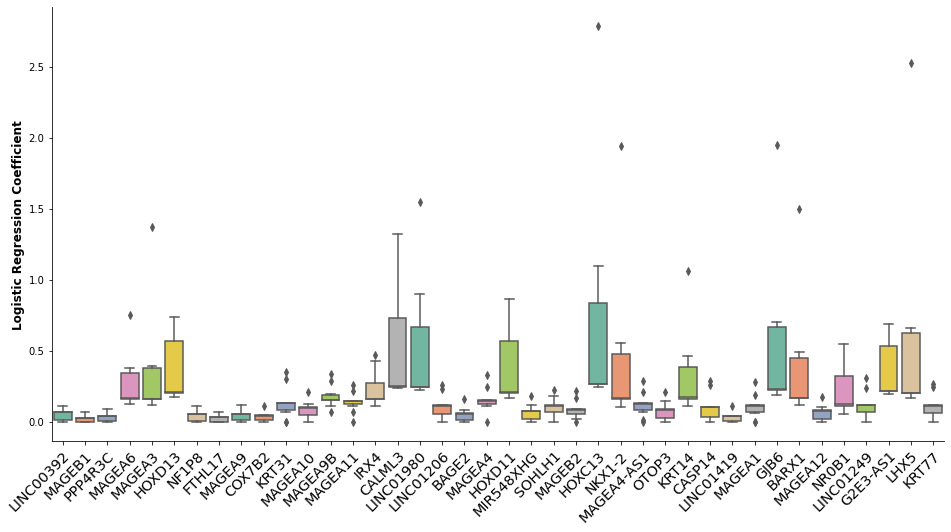

In [25]:
# let's plot the feature coefficient

fig, ax = plt.subplots(figsize=[16,8])
sns.boxplot(data=feat_coef, palette='Set2')
sns.despine()
plt.xticks(rotation=45, horizontalalignment='right', rotation_mode='anchor', fontweight='light', fontsize='x-large')
plt.ylabel('Logistic Regression Coefficient', fontsize=12, weight='bold')

In [26]:
best_C, best_l1_ratio = ([], [])

for i in range(len(lr_outer_cv['estimator'])):
    best_C.append(lr_outer_cv['estimator'][i].best_estimator_.C)
    best_l1_ratio.append(lr_outer_cv['estimator'][i].best_estimator_.l1_ratio)
    lr_best_params = pd.DataFrame({'C': best_C, 'l1_ratio': best_l1_ratio})

lr_best_params

,C,l1_ratio
0,0.01,0.10
1,0.10,0.10
2,1.00,0.75
3,0.01,0.00
4,0.01,0.00
5,0.01,0.00
6,0.01,0.00
7,0.10,0.00
8,0.01,0.00
9,0.10,0.50


In [27]:
lr_scores = lr_outer_cv['test_score']
lr_scores

array([0.99647266, 1.        , 1.        , 1.        , 0.99823633,
       0.99647266, 1.        , 0.99647266, 0.99470899, 1.        ])

In addition to Logistic Regression, let's use Random Forest. Since there is no CV version of the `RandomForestClassifier`, I will use `GridSearchCV` to search the hyperparameters space.

In [28]:
# let's configure the cross-validation loops
# for the outer loop, let's shuffle the data every time, and then split
# outer_splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 1)

# for the inner loop, let's shuffle the data once and then split
# inner_splitter = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

### nested cross validation ###

# instantiation of a logic regression classifier
rf_clf = RandomForestClassifier(random_state = 2,                            
                                class_weight = 'balanced'
                                )

# logisitc regression hyperparameter space
rf_params_grid = {'n_estimators': [50, 100, 200, 400, 800],
                  'max_depth'   : [2, 3, 4, 5, 6]}

# inner loop; for hyper-parameter tuning
rf_inner_cv = GridSearchCV(rf_clf, 
                           rf_params_grid,
                           cv=inner_splitter,
                           scoring='roc_auc',
                           refit = True,
                           return_train_score=True,
                           n_jobs=-1)

# outer loop; for model evaluation
rf_outer_cv = cross_validate(rf_inner_cv, std_mm_X_train, y_train,
                             scoring = 'roc_auc', cv = outer_splitter, n_jobs = -1,
                             return_train_score = True,
                             return_estimator = True)

In [29]:
# let's get the feature importance

fet_imp_list = []

for i in range(len(rf_outer_cv['estimator'])):
    fet_imp_list.append([rf_outer_cv['estimator'][i].best_estimator_.feature_importances_])

feat_imp = pd.DataFrame(np.concatenate(fet_imp_list), columns = std_mm_X_train.columns)
feat_imp

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2,...,LINC01419,MAGEA1,GJB6,BARX1,MAGEA12,NR0B1,LINC01249,G2E3-AS1,LHX5,KRT77
0,0.000000e+00,0.000000,0.000000,0.000000,0.011311,0.031208,0.000000,0.000000e+00,0.000000,0.000000,...,0.000607,0.000000,0.095518,0.056806,0.000000,0.004530,0.004098,0.023203,0.087339,0.018092
1,0.000000e+00,0.001611,0.000000,0.002970,0.012486,0.047802,0.000000,5.237778e-04,0.000000,0.000679,...,0.000844,0.000123,0.166159,0.072488,0.000000,0.000717,0.001934,0.039144,0.099613,0.000947
2,0.000000e+00,0.000887,0.000000,0.023842,0.002680,0.024534,0.000000,0.000000e+00,0.000782,0.000000,...,0.000000,0.001022,0.128849,0.112859,0.000386,0.000814,0.004758,0.043257,0.049275,0.000645
3,0.000000e+00,0.000000,0.000000,0.004322,0.012303,0.052083,0.000000,0.000000e+00,0.000000,0.000000,...,0.002772,0.000000,0.096866,0.094726,0.000000,0.000753,0.002273,0.026013,0.097238,0.015745
4,2.164470e-03,0.000431,0.000203,0.002536,0.006246,0.029245,0.000016,8.553811e-18,0.000173,0.001021,...,0.000923,0.000702,0.095909,0.094758,0.000698,0.003528,0.002928,0.023831,0.135093,0.013996
5,1.042523e-17,0.000015,0.000646,0.007068,0.007084,0.031888,0.000137,1.560701e-05,0.000170,0.002129,...,0.004085,0.000533,0.115889,0.094730,0.001146,0.003623,0.003946,0.037123,0.129542,0.015827
6,3.512871e-04,0.000315,0.000351,0.005838,0.009058,0.027409,0.000130,5.988424e-05,0.000135,0.000321,...,0.005003,0.000575,0.098552,0.089850,0.000662,0.001349,0.004686,0.027504,0.120534,0.022335
7,0.000000e+00,0.000000,0.000334,0.001736,0.000597,0.046879,0.000000,0.000000e+00,0.000000,0.000000,...,0.000386,0.001077,0.067209,0.111567,0.000000,0.001588,0.000514,0.027279,0.089584,0.016538
8,0.000000e+00,0.000000,0.000000,0.001708,0.014399,0.048450,0.000000,0.000000e+00,0.000000,0.000000,...,0.004047,0.000563,0.136975,0.064444,0.000000,0.001371,0.004597,0.023480,0.099850,0.000000
9,0.000000e+00,0.000000,0.000295,0.005550,0.006425,0.031217,0.000247,0.000000e+00,0.000000,0.000765,...,0.001365,0.000103,0.084403,0.097457,0.000810,0.001147,0.010075,0.052184,0.119085,0.019871


Text(0, 0.5, 'Random Forest Feature Importance')

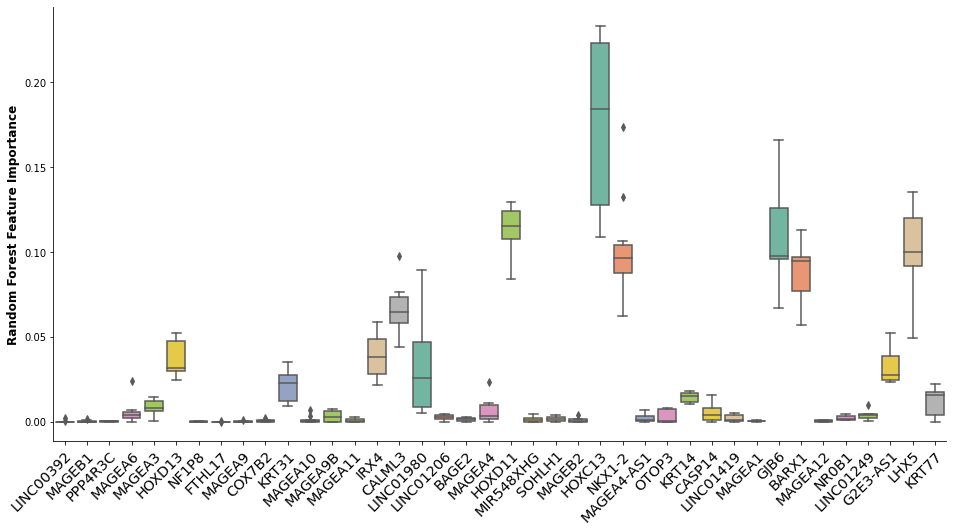

In [30]:
# let's plot the feature importance

fig, ax = plt.subplots(figsize=[16,8])
sns.boxplot(data=feat_imp, palette='Set2')
sns.despine()
plt.xticks(rotation=45, horizontalalignment='right', rotation_mode='anchor', fontweight='light', fontsize='x-large')
plt.ylabel('Random Forest Feature Importance', fontsize=12, weight='bold')

In [34]:
best_n_estimators, best_max_depth = ([], [])

for i in range(len(rf_outer_cv['estimator'])):
    best_n_estimators.append(rf_outer_cv['estimator'][i].best_estimator_.n_estimators)
    best_max_depth.append(rf_outer_cv['estimator'][i].best_estimator_.max_depth)
    rf_best_params = pd.DataFrame({'n_estimators': best_n_estimators, 'max_depth': best_max_depth})

rf_best_params

,n_estimators,max_depth
0,50,2
1,50,2
2,100,2
3,50,2
4,400,4
5,400,3
6,400,3
7,50,2
8,50,2
9,400,2


In [31]:
rf_scores = rf_outer_cv['test_score']
rf_scores

array([0.99470899, 0.99823633, 0.99823633, 1.        , 1.        ,
       1.        , 1.        , 0.99294533, 1.        , 1.        ])